In [101]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


df = pd.read_csv('telco_processed.csv')
print("Dataset shape:", df.shape)

Dataset shape: (7021, 30)


In [102]:
print("Columns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())

Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'TotalServices', 'HasInternet', 'TenureGroup', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

Data types:
gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity     

In [103]:
X = df.drop('Churn', axis=1)
y = df['Churn']

print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts())

Features shape: (7021, 29)
Target distribution:
Churn
0    5164
1    1857
Name: count, dtype: int64


In [104]:
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

print(f"\nCategorical columns: {categorical_cols.tolist()}")
print(f"Numerical columns: {numerical_cols.tolist()}")

for col in categorical_cols:
    print(f"\nColumn '{col}' unique values: {X[col].unique()}")


Categorical columns: ['TenureGroup']
Numerical columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'TotalServices', 'HasInternet']

Column 'TenureGroup' unique values: ['0-1yr' '2-4yr' '1-2yr' '4-6yr' nan]


In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (5616, 29)
Testing set: (1405, 29)


In [106]:
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])


In [107]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print("\nData scaling and encoding completed")
print(f"Processed training data shape: {X_train_scaled.shape}")
print(f"Processed test data shape: {X_test_scaled.shape}")

# Convert target to numerical if needed
if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)
    print(f"\nTarget classes: {le.classes_}")

print("\nTraining data - Mean:", X_train_scaled.mean(), "Std:", X_train_scaled.std())


Data scaling and encoding completed
Processed training data shape: (5616, 22)
Processed test data shape: (1405, 22)

Training data - Mean: 0.03154137529137528 Std: 0.921264530478582


In [108]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Re-enable warnings
warnings.filterwarnings('default')

print("Neural Network architecture:")
model.summary()

Neural Network architecture:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8408 - loss: 0.3660 - val_accuracy: 0.7918 - val_loss: 0.4638
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8399 - loss: 0.3672 - val_accuracy: 0.7883 - val_loss: 0.4727
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8406 - loss: 0.3606 - val_accuracy: 0.7891 - val_loss: 0.4703
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - loss: 0.3652 - val_accuracy: 0.7883 - val_loss: 0.4675
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8328 - loss: 0.3670 - val_accuracy: 0.7927 - val_loss: 0.4754
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8386 - loss: 0.3639 - val_accuracy: 0.7883 - val_loss: 0.4771
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8406 - loss: 0.3659 - val_accuracy: 0.7891 - val_loss: 0.4742
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8324 - loss: 0.3711 - val_accu

In [110]:
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print("=== BASIC NEURAL NETWORK PERFORMANCE ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

=== BASIC NEURAL NETWORK PERFORMANCE ===
Training Accuracy: 0.8356
Testing Accuracy: 0.7772


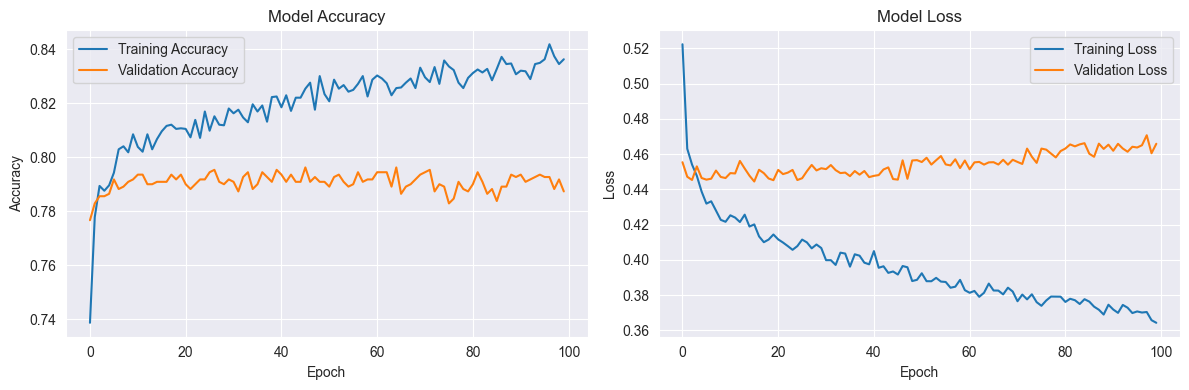

In [111]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [112]:
nn_basic_results = {
    'model': 'NeuralNetwork_Basic',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'architecture': '64-32-1 with Dropout'
}

print("Basic Neural Network results saved")

Basic Neural Network results saved
